In [1]:
import numpy as np
import pandas as pd
import os
import random
import json
import ast
import nltk
import re
import cv2
from skimage import io
import matplotlib
import matplotlib.pyplot as plt
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import normalize
from requests.exceptions import HTTPError

In [2]:
plt.rcParams["figure.figsize"] = [12,8]
def yearlist(start, end):
    ans = []
    for x in xrange(start, end + 1):
        ans.append(x)
    return ans
obj_dic = {}
def add_dic(x):
    for ele in x.split(","):
        if ele in obj_dic:
            obj_dic[ele] += 1
        else:
            obj_dic[ele] = 1
    return 0

#Sentiment Analysis Help Functions
def get_wordnet_pos(treebank_tag):
    string, tag = treebank_tag
    string = string.lower()
    treebank_tag = tag.upper()
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'X'
def wordnet_sanitize(word):
    string, tag = word
    string = string.lower()
    tag = tag.lower()
    if tag.startswith('v'):    tag = 'v'
    elif tag.startswith('n'):  tag = 'n'
    elif tag.startswith('j'):  tag = 'a'
    elif tag.startswith('rb'): tag = 'r'
    if tag in ('a', 'n', 'r', 'v'):
        return (string, tag)
    else:
        return (string, None)

#Box Plot Coloring
def boxplot_color(bp):
    for box in bp['boxes']:
        # change outline color
        box.set( color='#7570b3', linewidth=2)
        # change fill color
        box.set( facecolor = '#1b9e77' )

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='#b2df8a', linewidth=2)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='#e7298a', alpha=0.5)

In [3]:
oscar = pd.read_csv("./oscars.csv", header = 0)
oscar = map(lambda x : str(re.sub(r'[^\x00-\x7F]+',"",str(x.lower().replace(" ","")))) ,list(oscar['Movie_Name']))

In [4]:
#Load All Scrapped Data
google_movies_folder = "./google-movies"
facebook_movie_folder = "./facebook-movies"
imdb_movie_folder = "./imdb-movies"
years = yearlist(2008,2016)
dic_google, dic_fb, dic_imdb, dic_people = {}, {}, {}, {}
for year in years:
    dic_google[year] = pd.read_csv(google_movies_folder + "/movie-data-" + str(year) + ".csv", header = 0)
    dic_fb[year] = pd.read_csv(facebook_movie_folder + "/movie-data-" + str(year) + ".csv", header = 0)
    dic_imdb[year] = pd.read_csv(imdb_movie_folder + "/movie-data-" + str(year) + ".csv", header = None)
    dic_people[year] = pd.read_csv(imdb_movie_folder + "/movie-info-" + str(year) + ".csv", header = 0)
    dic_imdb[year].columns = ['id','title','score','rating','review']

In [5]:
#Find All Genres from movies - Refine
list_genres = []
years = yearlist(2008,2016)
for year in years:
    obj = dic_google[year]
    for line in xrange(len(obj)):
        if len(ast.literal_eval(obj[line:line + 1]['genres'][line])) > 0:
            elements = ast.literal_eval(str(obj[line:line + 1]['genres'][line]))
            gen = ""
            for ele in elements:
                gen = gen + ele['name'] + ","
                if ele['name'] not in list_genres:
                    list_genres.append(ele['name'])
            obj.loc[line,"genres"] = str(gen[:-1])
list_genres = map(str, list_genres)

In [6]:
#Find All production Houses from movies - Refine
list_prod = []
years = yearlist(2008,2016)
for year in years:
    obj = dic_google[year]
    for line in xrange(len(obj)):
        if len(ast.literal_eval(obj[line:line + 1]['production'][line])) > 0:
            elements = ast.literal_eval(str(obj[line:line + 1]['production'][line]))
            gen = ""
            for ele in elements:
                gen = gen + ele['name'] + ","
                if ele['name'] not in list_genres:
                    list_prod.append(ele['name'].encode("utf8"))
            obj.loc[line,"production"] = str(gen[:-1].encode("utf8"))
list_prod = map(str, list_prod)

In [7]:
#Genres Hot Encoding
years = yearlist(2008,2016)
for year in years:
    dic_google[year]['year'] = year
for year in years:
    for ls in list_genres:
        dic_google[year][ls] = dic_google[year]['genres'].apply(lambda x: 1 if ls in x.split(",") else 0)

In [8]:
#Count all production houses and genres
dic_prod, dic_genre = {}, {}
obj_dic = dic_prod
years = yearlist(2008,2016)
for year in years:
    dic_google[year]['production'].apply(add_dic)
del dic_prod[' The']
dic_prod = sorted(dic_prod.iteritems(), key=lambda (k,v): (v,k), reverse= True)
obj_dic = dic_genre
for year in years:
    dic_google[year]['genres'].apply(add_dic)
dic_genre = sorted(dic_genre.iteritems(), key=lambda (k,v): (v,k), reverse= True)
dic_genre = dic_genre[:-1]

Figure Size [12.0, 8.0]


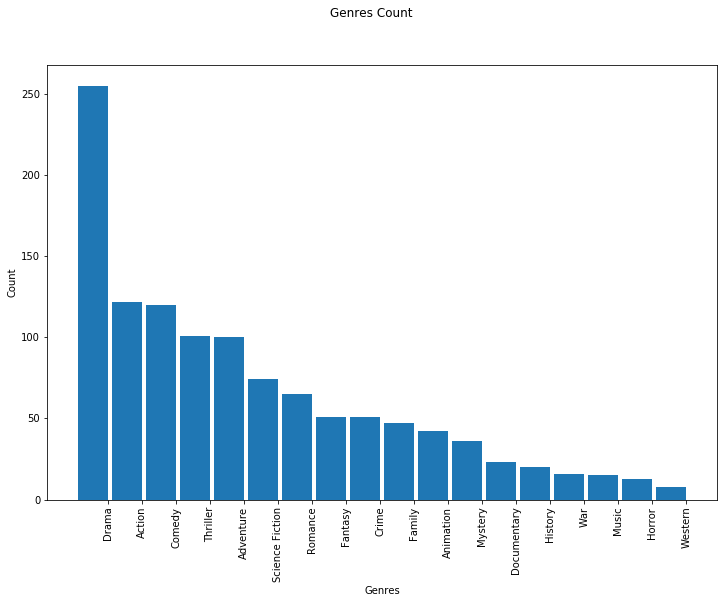

In [9]:
keys = map(lambda x : str(x[0]), dic_genre)
values = map(lambda x : str(x[1]), dic_genre)
indexes = np.arange(len(keys))
width = .9
plt.suptitle("Genres Count")
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, keys, rotation='vertical')
plt.ylabel('Count')
plt.xlabel('Genres')
fig_size = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = fig_size
print "Figure Size",fig_size
plt.show()

Figure Size [12.0, 8.0]


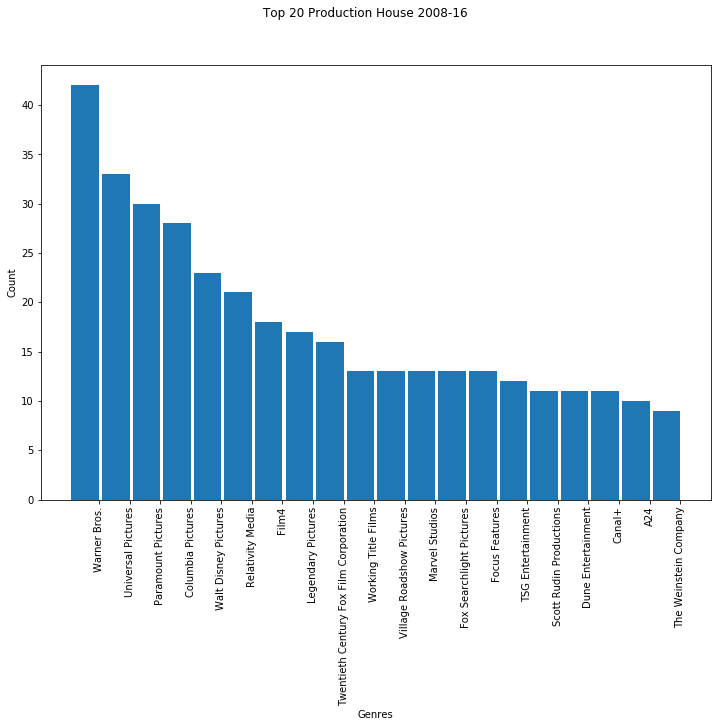

In [303]:
keys = map(lambda x : str(re.sub(r'[^\x00-\x7F]+','', str(x[0]))), dic_prod[:20])
values = map(lambda x : x[1], dic_prod[:20])
indexes = np.arange(len(keys))
width = .9
plt.suptitle("Top 20 Production House 2008-16")
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, keys, rotation='vertical')
plt.ylabel('Count')
plt.xlabel('Genres')
fig_size = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = fig_size
print "Figure Size",fig_size
plt.show()

In [10]:
#Sentiment Analysis of Overview
tokenizer = RegexpTokenizer(r'\w+')
stemmer = WordNetLemmatizer()
years = yearlist(2008,2016)
for year in years:
    obj = dic_google[year]
    obj['overview_pos_score'] = 0
    obj['overview_neg_score'] = 0
    for line in xrange(len(obj)):
        sentence = re.sub(r'[^\x00-\x7F]+','', str(obj.loc[line,"overview"]))
        sentence = re.sub("\d+", "", sentence)
        sentence = tokenizer.tokenize(sentence)
        sentence = [word.lower() for word in sentence if word not in stopwords.words('english')]
        sentence = [str(stemmer.lemmatize(plural,get_wordnet_pos(nltk.pos_tag([plural])[0]))) if get_wordnet_pos(nltk.pos_tag([plural])[0]) != 'X' else str(stemmer.lemmatize(plural)) for plural in sentence]
        sentiment = map(lambda x : swn.senti_synsets(str(x), wordnet_sanitize(nltk.pos_tag([x])[0])[1]), sentence)
        obj.loc[line,'overview_pos_score'] = sum(map(lambda x : x[0].pos_score() if len(x) > 0 else 0, sentiment))/len(sentiment)
        obj.loc[line,'overview_neg_score'] = sum(map(lambda x : x[0].neg_score() if len(x) > 0 else 0, sentiment))/len(sentiment)

In [11]:
#Face Information
movie_path = "https://image.tmdb.org/t/p/w500"
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
profile_cascade = cv2.CascadeClassifier('haarcascade_profileface.xml')
years = yearlist(2008,2016)
for year in years:
    obj = dic_google[year]
    obj['faces'] = 0
    for line in xrange(len(obj)):
        if str(obj.loc[line, 'poster']) != "nan":
            url = movie_path + str(obj.loc[line, 'poster'])
            try:
                image = io.imread(url)
                img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                front_faces = face_cascade.detectMultiScale(gray, 1.05, 5)
                profile_faces = profile_cascade.detectMultiScale(gray, 1.05, 5)
                obj.loc[line, 'faces'] = len(front_faces) + len(profile_faces)
            except HTTPError:
                print url
    print "Posters for",year,"Done!"

Posters for 2008 Done!
Posters for 2009 Done!
Posters for 2010 Done!
Posters for 2011 Done!
Posters for 2012 Done!
Posters for 2013 Done!
Posters for 2014 Done!
Posters for 2015 Done!
Posters for 2016 Done!


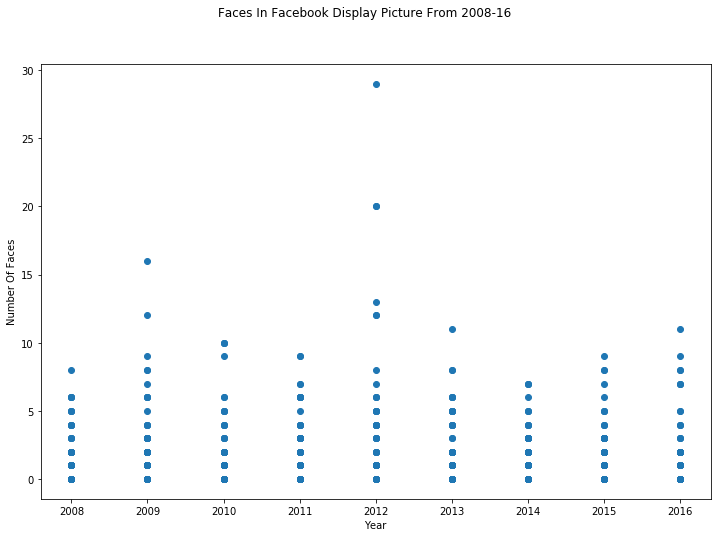

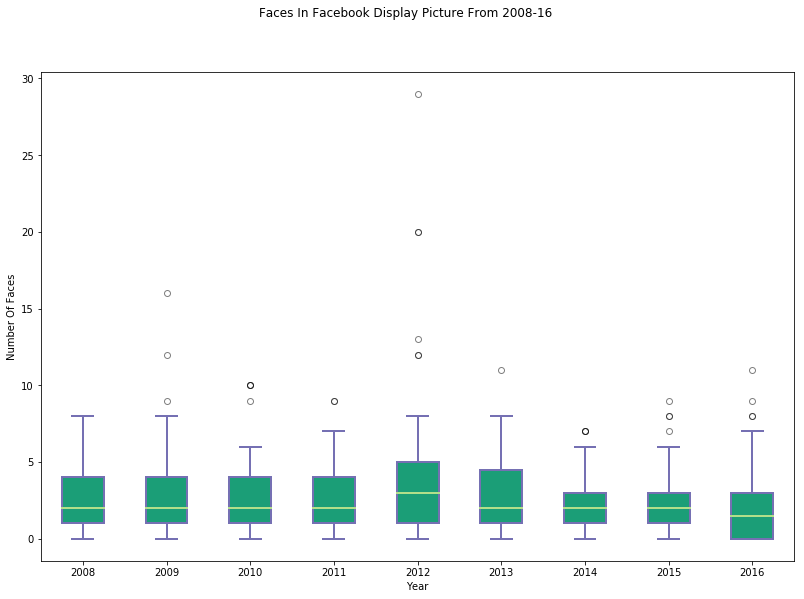

In [12]:
#Number Of Faces Per Year Plot
x = []
y = []
years = yearlist(2008,2016)
for year in years:
    obj = dic_google[year]
    x += list(obj['year'])
    y += list(obj['faces'])
plt.plot(x, y, "o")
plt.suptitle("Faces In Facebook Display Picture From 2008-16")
plt.ylabel('Number Of Faces')
plt.xlabel('Year')
plt.show()

y = []
for year in years:
    obj = dic_google[year]
    y.append(list(obj['faces']))
fig = plt.figure(1, figsize=(13.5, 9))
ax = fig.add_subplot(111)
bp = ax.boxplot(y, patch_artist=True)
boxplot_color(bp)
plt.suptitle("Faces In Facebook Display Picture From 2008-16")
ax.set_xticklabels(years)
plt.ylabel('Number Of Faces')
plt.xlabel('Year')
plt.show()

In [13]:
#Concat FB Likes
years = yearlist(2008,2016)
for year in years:
    obj = dic_google[year]
    fb = dic_fb[year]
    obj['fb_likes'] = 0
    for line in xrange(len(obj)):
        find_movie = fb[fb['title'] == str(obj.loc[line,'title'])]['likes']
        if len(find_movie) > 0:
            obj.loc[line, 'fb_likes'] = int(find_movie.sum() / len(find_movie))

Figure Size [12.0, 8.0]
OSCAR MOVIES ARE HIGHLIGHTED WITH RED


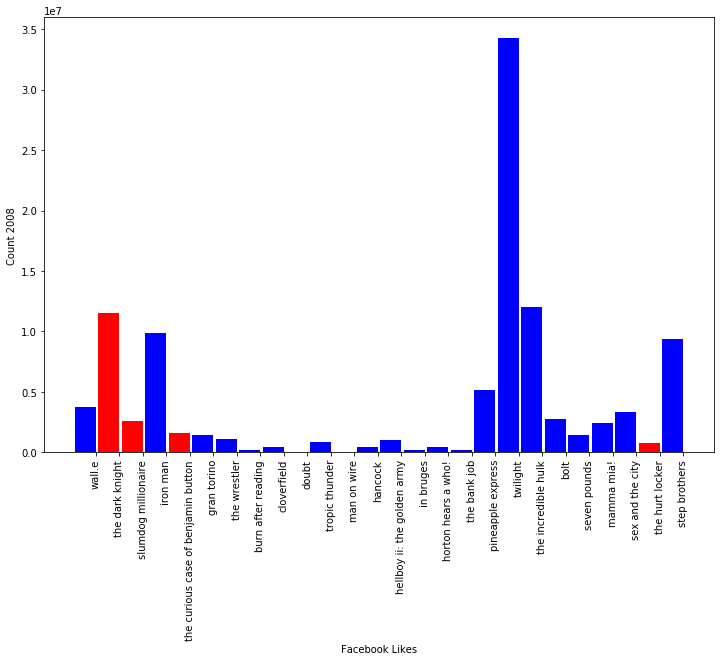

Figure Size [12.0, 8.0]
OSCAR MOVIES ARE HIGHLIGHTED WITH RED


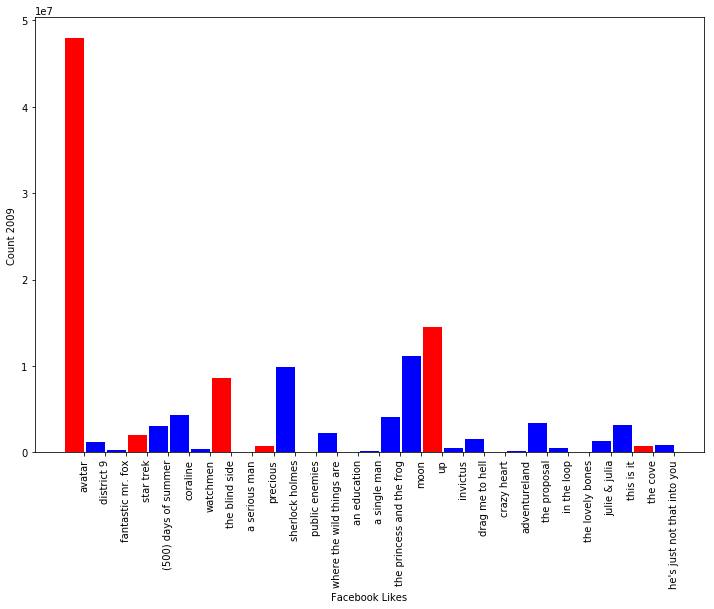

Figure Size [12.0, 8.0]
OSCAR MOVIES ARE HIGHLIGHTED WITH RED


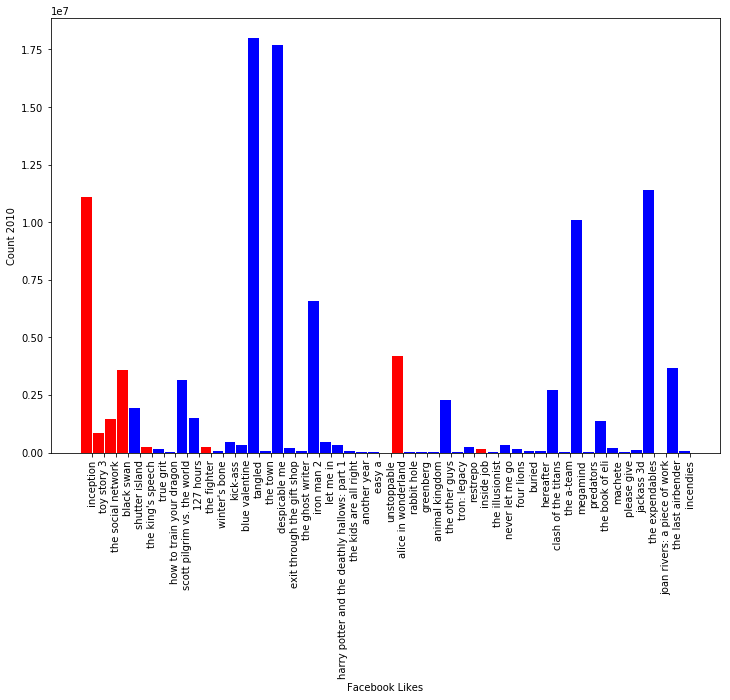

Figure Size [12.0, 8.0]
OSCAR MOVIES ARE HIGHLIGHTED WITH RED


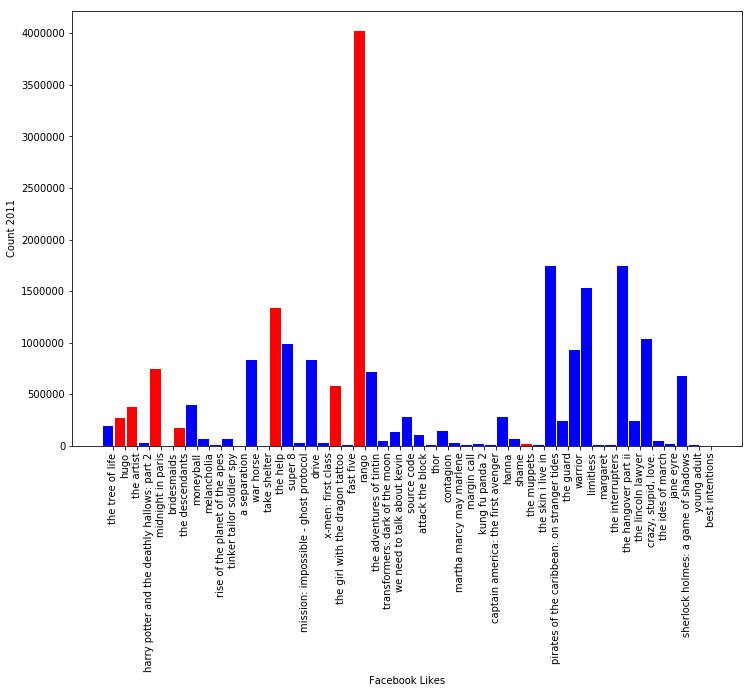

Figure Size [12.0, 8.0]
OSCAR MOVIES ARE HIGHLIGHTED WITH RED


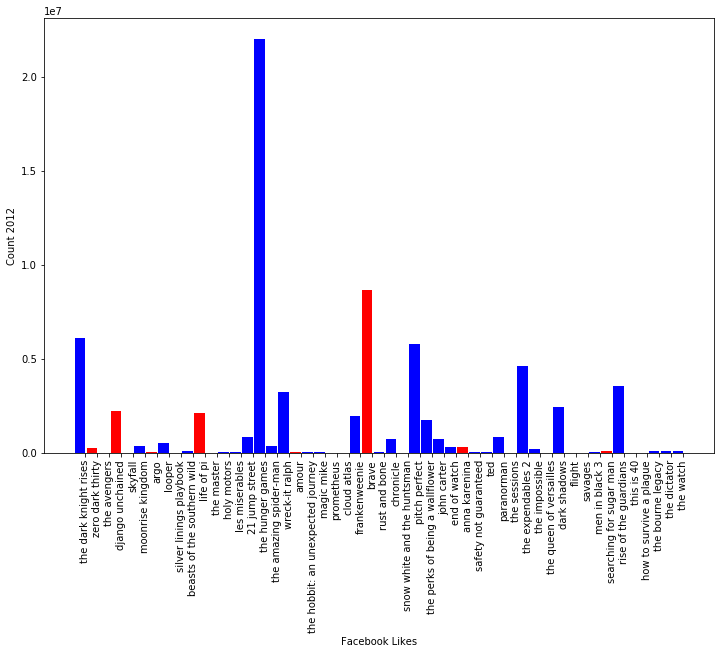

Figure Size [12.0, 8.0]
OSCAR MOVIES ARE HIGHLIGHTED WITH RED


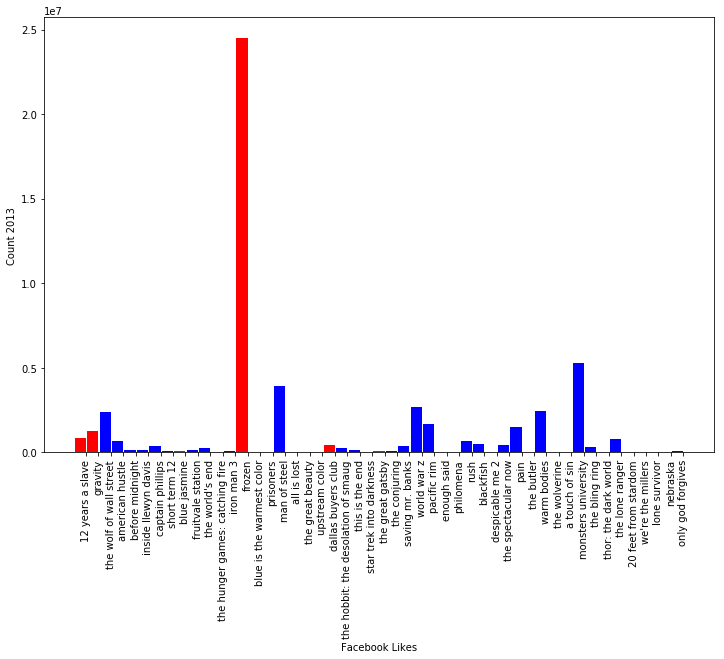

Figure Size [12.0, 8.0]
OSCAR MOVIES ARE HIGHLIGHTED WITH RED


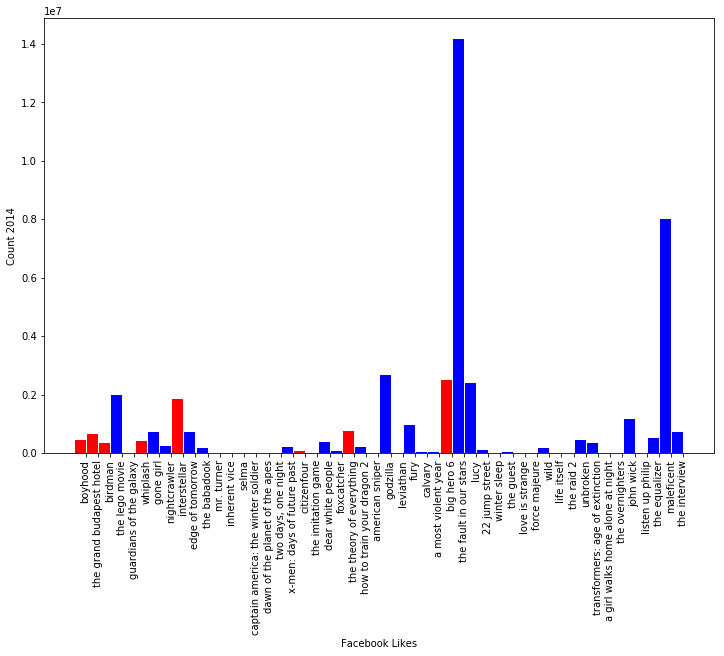

Figure Size [12.0, 8.0]
OSCAR MOVIES ARE HIGHLIGHTED WITH RED


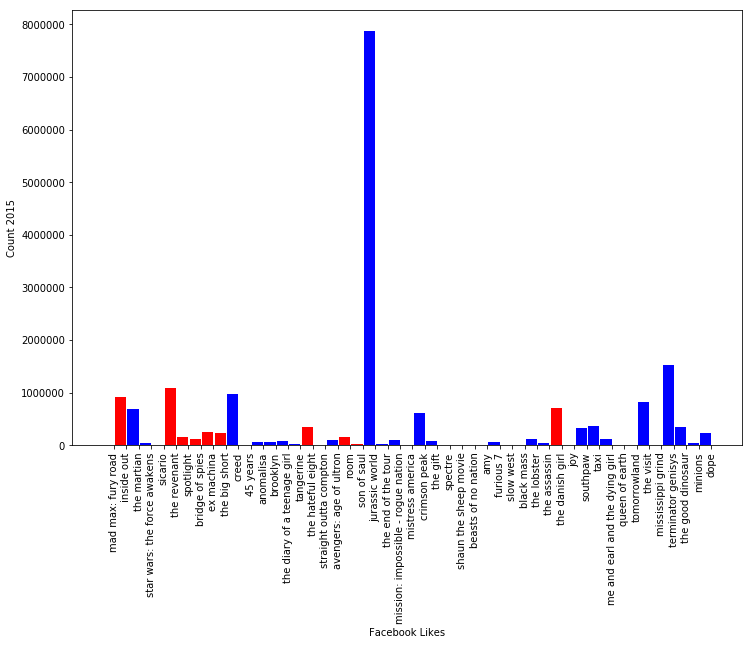

Figure Size [12.0, 8.0]
OSCAR MOVIES ARE HIGHLIGHTED WITH RED


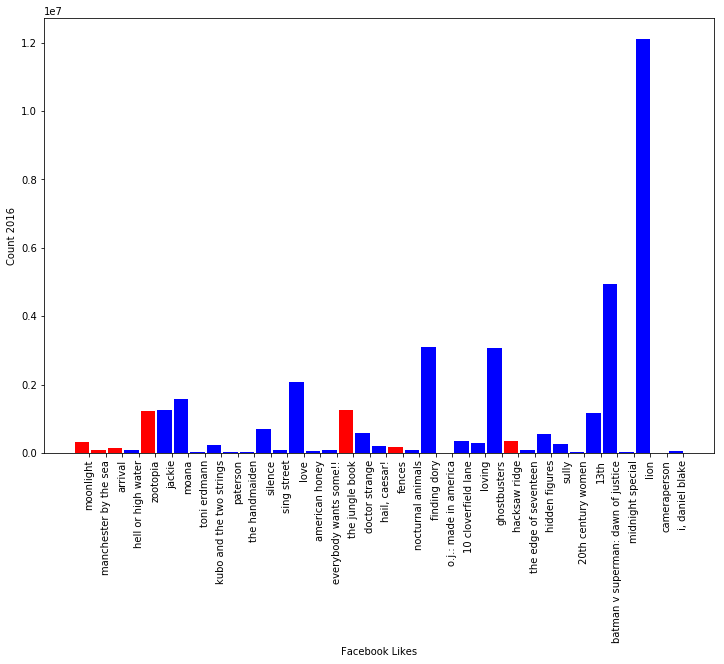

In [14]:
#FB Likes Plot
years = yearlist(2008,2016)
fig = {}
count = 1
width = .9
for year in years:
    obj = dic_google[year]
    result = obj[obj['fb_likes'] != 0][['title','fb_likes']]
    keys = list(result['title'])
    values = list(result['fb_likes'])
    colors = []
    for k in keys:
        if str(re.sub(r'[^\x00-\x7F]+',"",str(k.lower().replace(" ","")))) in oscar:
               colors.append('r')
        else:
               colors.append('b')
    indexes = np.arange(len(keys))
    fig[year] = plt.figure(count)
    plt.bar(indexes, values, width, color=colors)
    plt.xticks(indexes + width * 0.5, keys, rotation='vertical')
    plt.ylabel('Count ' + str(year))
    plt.xlabel('Facebook Likes')
    fig_size = plt.rcParams["figure.figsize"]
    print "Figure Size",fig_size
    print "OSCAR MOVIES ARE HIGHLIGHTED WITH RED"
    count += 1
    plt.show()

In [15]:
#Concat IMDB score and ratings
years = yearlist(2008,2016)
for year in years:
    dic_google[year][['score','rating']] = dic_imdb[year][['score','rating']] 

In [16]:
years = yearlist(2008,2016)
for year in years:
    obj = dic_google[year]
    people = dic_people[year]
    obj['director'], obj['cast'], obj['producer'] = "", "", ""
    try:
        obj['director'] = people['people'].apply(lambda x : ",".join(map(lambda y : str(y[0].encode("utf8")) , ast.literal_eval(x)['directors'] if 'directors' in ast.literal_eval(x) else [])))
        obj['cast'] = people['people'].apply(lambda x : ",".join(map(lambda y : str(y[0].encode("utf8")) , ast.literal_eval(x)['cast'] if 'cast' in ast.literal_eval(x) else [])))
        obj['producer'] = people['people'].apply(lambda x : ",".join(map(lambda y : str(y[0].encode("utf8")) , ast.literal_eval(x)['producers'] if 'producers' in ast.literal_eval(x) else [])))
    except KeyError:
        print year,"Key Error"

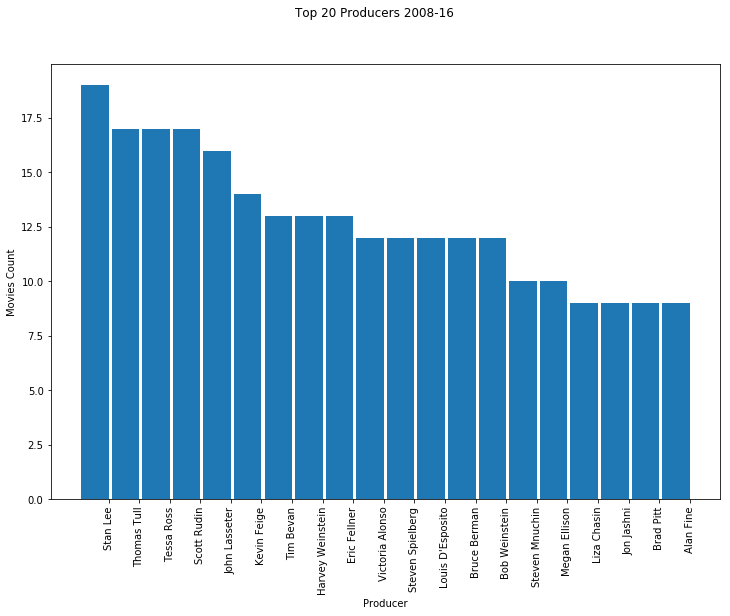

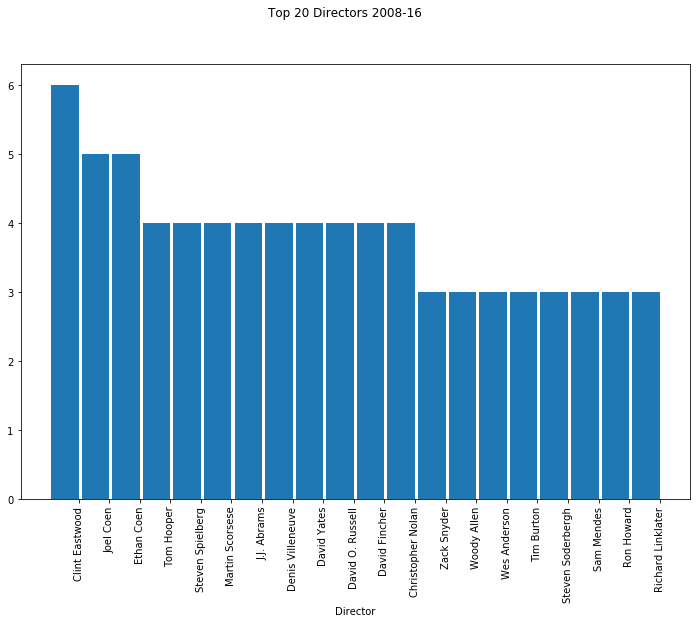

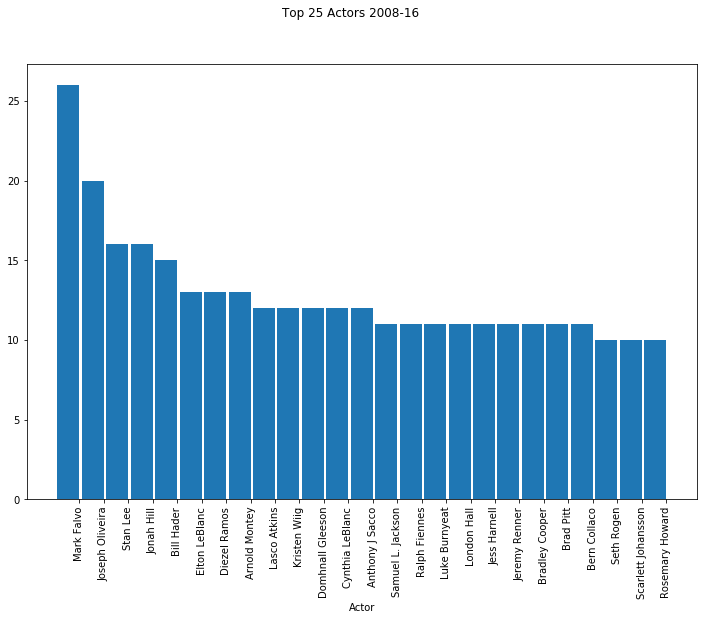

In [17]:
#Top Actors, Producers and Directors
dic_actors, dic_directors, dic_producers = {}, {}, {}
width = .9
plt.ylabel('Movies Count')
years = yearlist(2008,2016)
obj_dic = dic_actors
for year in years:
    dic_google[year]['cast'].apply(add_dic)
dic_actors = sorted(dic_actors.iteritems(), key=lambda (k,v): (v,k), reverse= True)
obj_dic = dic_directors
for year in years:
    dic_google[year]['director'].apply(add_dic)
dic_directors = sorted(dic_directors.iteritems(), key=lambda (k,v): (v,k), reverse= True)
obj_dic = dic_producers
for year in years:
    dic_google[year]['producer'].apply(add_dic)
dic_producers = sorted(dic_producers.iteritems(), key=lambda (k,v): (v,k), reverse= True)

keys = map(lambda x : str(re.sub(r'[^\x00-\x7F]+','', str(x[0]))), dic_producers[:20])
values = map(lambda x : x[1], dic_producers[:20])
indexes = np.arange(len(keys))
plt.suptitle("Top 20 Producers 2008-16")
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, keys, rotation='vertical')
plt.xlabel('Producer')
plt.show()
keys = map(lambda x : str(re.sub(r'[^\x00-\x7F]+','', str(x[0]))), dic_directors[:20])
values = map(lambda x : x[1], dic_directors[:20])
indexes = np.arange(len(keys))
plt.suptitle("Top 20 Directors 2008-16")
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, keys, rotation='vertical')
plt.xlabel('Director')
plt.show()
keys = map(lambda x : str(re.sub(r'[^\x00-\x7F]+','', str(x[0]))), dic_actors[:25])
values = map(lambda x : x[1], dic_actors[:25])
indexes = np.arange(len(keys))
plt.suptitle("Top 25 Actors 2008-16")
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, keys, rotation='vertical')
plt.xlabel('Actor')
plt.show()

In [19]:
#Review Sentiment Analysis
review_path = "./imdb-movies/reviews/"
tokenizer = RegexpTokenizer(r'\w+')
stemmer = WordNetLemmatizer()
years = yearlist(2008,2016)
for year in years:
    obj = dic_google[year]
    imdb = obj['imdb']
    obj['IMDB_review_sentiment_pos'] = 0
    obj['IMDB_review_sentiment_neg'] = 0
    obj['IMDB_review_helpful_metric'] = 0
    obj['IMDB_review_rating'] = 0
    obj['IMDB_review_neutral_metric'] = 0
    print ""
    print year,"started ..."
    for line in xrange(len(imdb)):
        #line = 47
        print obj.loc[line,'title'], "Review Sentiment Analysis Started"
        rfile = open(review_path + "movie-" + imdb[line], 'r')
        if len(rfile.readline()) > 0:
            review, user_score, helpful, t_people = [], "", 0, 0
            total_score, helpful_ratio, neutral_to_helpful_ratio = 0.0, 0.0, 0.0
            review_status, line_count, review_count = True, 1, 0
            fault_score, fault_helpful = 0, 0
            for textline in rfile:
                if review_status:
                    text = textline
                    if "###" in str(text):
                        #print text
                        review_status = False
                        line_count = 1
                        '''
                        if len(review[-1]) <= 8:
                            user_score = review[-1][:-1]
                            review = review[:-1]
                        '''
                        continue
                    review.append(text)
                else:
                    if line_count == 3:
                        potential_score = textline
                        if "None" not in potential_score:
                            user_score = potential_score[:-1]
                    elif line_count == 9:
                        if "None" not in textline:
                            #print user_score,textline
                            helpful = int(textline[:-1])
                        else:
                            helpful = 0
                    elif line_count == 11:
                        if "None" not in textline:
                            t_people = int(textline[:-1])
                        else:
                            t_people = 0
                    elif line_count == 12:
                        review_status = True
                        review_count += 1
                        #print ""
                        #print review_count, review
                        if len(user_score) == 0:
                            fault_score += 1
                        else:
                            #print user_score
                            total_score += float(user_score.split("/")[0])
                        if helpful == 0 or t_people == 0:
                            fault_helpful += 1
                        else:
                            helpful_ratio += float(float(helpful)/t_people)
                            neutral_to_helpful_ratio += float(float(t_people - helpful)/helpful)
                        user_score, helpful, t_people = "", 0, 0
                    line_count += 1
            #Summarize Reviews For Movie
            total_score += fault_score * (total_score / (review_count - fault_score))
            helpful_ratio += fault_helpful * (helpful_ratio / (review_count - fault_helpful))
            neutral_to_helpful_ratio += fault_helpful * (neutral_to_helpful_ratio / (review_count - fault_helpful))
            count = 0
            for text in review:
                text = text.replace('\n','').lower()
                text = re.sub(r'[^\x00-\x7F]+','', text)
                text = re.sub('[^a-zA-Z ]+', '', text)
                text = " ".join([word for word in text.split(' ') if word not in stopwords.words('english')])
                if len(text) > 0:
                    review[count] = text
                count += 1
            review = [word for word in review if '\n' not in word]
            total_score = total_score / review_count
            helpful_ratio = helpful_ratio / review_count
            neutral_to_helpful_ratio = neutral_to_helpful_ratio / review_count
            review = re.sub(' +',' '," ".join(review))
            review = tokenizer.tokenize(review)
            review = [str(stemmer.lemmatize(plural,get_wordnet_pos(nltk.pos_tag([plural])[0]))) if get_wordnet_pos(nltk.pos_tag([plural])[0]) != 'X' else str(stemmer.lemmatize(plural)) for plural in review]
            review = map(lambda x : swn.senti_synsets(str(x), wordnet_sanitize(nltk.pos_tag([x])[0])[1]), review)
            #Add New Features After Sentiment Analysis on Movie Reviews
            obj.loc[line,'IMDB_review_sentiment_pos'] = sum(map(lambda x : x[0].pos_score() if len(x) > 0 else 0, review))/len(review)
            obj.loc[line,'IMDB_review_sentiment_neg'] = sum(map(lambda x : x[0].neg_score() if len(x) > 0 else 0, review))/len(review)
            obj.loc[line,'IMDB_review_helpful_metric'] = helpful_ratio
            obj.loc[line,'IMDB_review_rating'] = total_score
            obj.loc[line,'IMDB_review_neutral_metric'] = neutral_to_helpful_ratio
            #print review, total_score, helpful_ratio, neutral_to_helpful_ratio  


2008 started ...
wall.e Review Sentiment Analysis Started
the dark knight Review Sentiment Analysis Started
slumdog millionaire Review Sentiment Analysis Started
iron man Review Sentiment Analysis Started
the curious case of benjamin button Review Sentiment Analysis Started
gran torino Review Sentiment Analysis Started
indiana jones and the kingdom of the crystal skull Review Sentiment Analysis Started
the wrestler Review Sentiment Analysis Started
quantum of solace Review Sentiment Analysis Started
kung fu panda Review Sentiment Analysis Started
let the right one in Review Sentiment Analysis Started
burn after reading Review Sentiment Analysis Started
the black list: volume one Review Sentiment Analysis Started
cloverfield Review Sentiment Analysis Started
frost/nixon Review Sentiment Analysis Started
doubt Review Sentiment Analysis Started
tropic thunder Review Sentiment Analysis Started
man on wire Review Sentiment Analysis Started
hancock Review Sentiment Analysis Started
vicky cr

In [20]:
#Join year Wise Dataset
final_google = pd.concat([dic_google[year] for year in yearlist(2008,2016)])

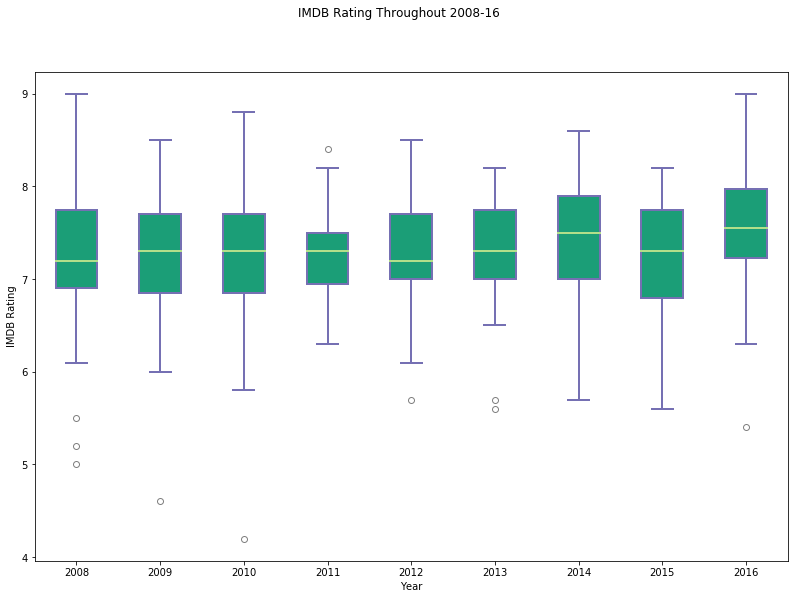

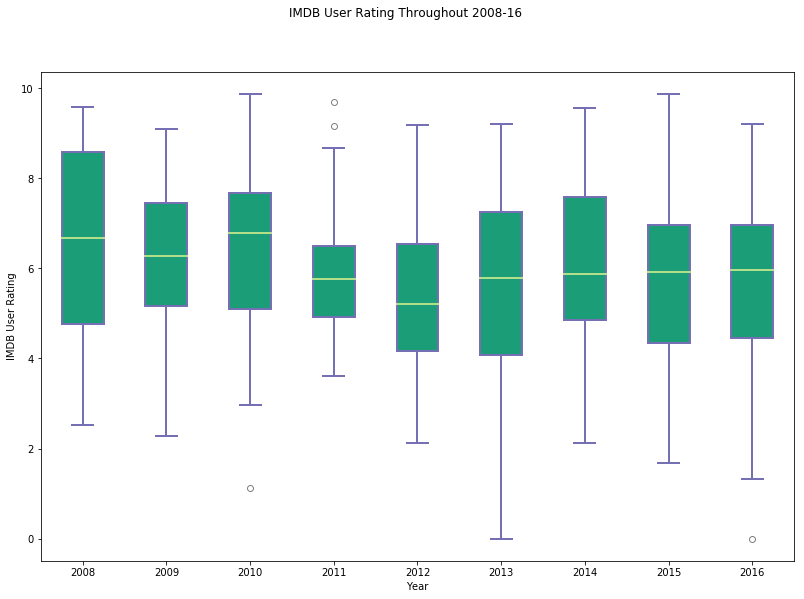

In [21]:
#IMDB User Rating VS Year
year_score, year_user_score = [], []
years = yearlist(2008,2016)
for year in years:
    obj = dic_google[year]
    year_score.append(list(obj['score']))
    year_user_score.append(list(obj['IMDB_review_rating']))
indexes = np.arange(len(years))
fig = plt.figure(1, figsize=(13.5, 9))
ax = fig.add_subplot(111)
bp = ax.boxplot(year_score, patch_artist=True)
boxplot_color(bp)
plt.suptitle("IMDB Rating Throughout 2008-16")
ax.set_xticklabels(years)
plt.ylabel('IMDB Rating')
plt.xlabel('Year')
plt.show()

fig = plt.figure(2, figsize=(13.5, 9))
ax = fig.add_subplot(111)
bp = ax.boxplot(year_user_score, patch_artist=True)
boxplot_color(bp)
plt.suptitle("IMDB User Rating Throughout 2008-16")
ax.set_xticklabels(years)
plt.ylabel('IMDB User Rating')
plt.xlabel('Year')
plt.show()

In [22]:
#Preprocess Certificates
certificate = pd.get_dummies(final_google['rating'], prefix = "certificate",  dummy_na=False)
final_google = pd.concat([final_google, certificate], axis=1, join='inner')

In [23]:
#Getting Ready For Regression Analysis
intersting_columns = [u'title', u'IMDB_review_rating', u'score', u'IMDB_review_helpful_metric', u'IMDB_review_neutral_metric', u'IMDB_review_sentiment_neg', u'IMDB_review_sentiment_pos', u'budget', u'faces', u'fb_likes', u'overview_neg_score', u'overview_pos_score',  u'revenue', u'runtime', u'Action', u'Adventure', u'Animation', u'Comedy', u'Crime', u'Documentary', u'Drama', u'Family', u'Fantasy', u'History', u'Horror', u'Music', u'Mystery', u'Romance', u'Science Fiction', u'Thriller', u'War', u'Western', u'certificate_12', u'certificate_13', u'certificate_16', u'certificate_A.G.', u'certificate_G', u'certificate_NC-17', u'certificate_Not Rated', u'certificate_PG', u'certificate_PG-13', u'certificate_R', u'certificate_TV-14', u'certificate_TV-MA', u'certificate_TV-PG', u'certificate_Unrated']
regression = final_google[intersting_columns]
final_google[intersting_columns].describe()

,IMDB_review_rating,score,IMDB_review_helpful_metric,IMDB_review_neutral_metric,IMDB_review_sentiment_neg,IMDB_review_sentiment_pos,budget,faces,fb_likes,overview_neg_score,...,certificate_G,certificate_NC-17,certificate_Not Rated,certificate_PG,certificate_PG-13,certificate_R,certificate_TV-14,certificate_TV-MA,certificate_TV-PG,certificate_Unrated
count,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,4.570000e+02,457.000000,4.570000e+02,457.000000,...,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000
mean,5.981328,7.294967,0.677632,0.515748,0.039680,0.053713,6.108593e+07,2.746171,1.267565e+06,0.037390,...,0.008753,0.004376,0.026258,0.085339,0.354486,0.455142,0.006565,0.013129,0.019694,0.006565
std,1.898766,0.644338,0.094402,0.185119,0.005996,0.007006,7.152918e+07,3.100847,3.908209e+06,0.027777,...,0.093248,0.066082,0.160077,0.279692,0.478881,0.498529,0.080844,0.113952,0.139098,0.080844
min,0.000000,4.200000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.583333,7.000000,0.624548,0.409820,0.036260,0.050546,7.000000e+06,1.000000,4.818000e+03,0.017857,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.960000,7.300000,0.668078,0.523272,0.039379,0.053676,3.000000e+07,2.000000,9.308200e+04,0.032895,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.476190,7.800000,0.725631,0.621879,0.042958,0.057027,1.000000e+08,4.000000,7.391070e+05,0.053191,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,9.880000,9.000000,0.939548,2.000000,0.057624,0.074739,3.800000e+08,29.000000,4.794699e+07,0.182692,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
pd.DataFrame({ 'Final_DataSet_Column_Names' : list(final_google.columns) })

,Final_DataSet_Column_Names
0,title_g
1,title
2,overview
3,production
4,release
5,revenue
6,budget
7,runtime
8,tagline
9,imdb


In [25]:
non_zero_regression = regression[(regression['budget']!=0) & (regression['fb_likes']!=0) & (regression['revenue']!=0) & (regression['runtime']!=0) & (regression['score']!=0) & (regression['IMDB_review_rating']!=0)]
pd.DataFrame({ 'Regression_DataSet_Column_Names' : list(non_zero_regression.columns) })

,Regression_DataSet_Column_Names
0,title
1,IMDB_review_rating
2,score
3,IMDB_review_helpful_metric
4,IMDB_review_neutral_metric
5,IMDB_review_sentiment_neg
6,IMDB_review_sentiment_pos
7,budget
8,faces
9,fb_likes


In [39]:
#Regression Analysis Of Movies IMDB_User_Rating
reg_l = linear_model.ElasticNet(alpha = 0.0075, l1_ratio = 1, normalize=False, fit_intercept=True, copy_X=True)
reg_r= linear_model.Ridge(alpha = .01, normalize=False, fit_intercept=True, copy_X=True)
data = np.asarray(non_zero_regression)
x, y = data[:, 2:], data[:, 1]
x = normalize(x, norm='max', axis=0, copy=True, return_norm=False)
x_train, y_train = x[:300], y[:300]
this_scores = cross_val_score(reg_r, x_train, y_train, cv=10, n_jobs=1)
print "10-Fold Validation Scores",this_scores
reg_l.fit(x_train,y_train)
reg_r.fit(x_train,y_train)
print ""
print "Elastic Net R2", r2_score(y[300:], reg_l.predict(x[300:]))
print "Ridge R2", r2_score(y[300:], reg_r.predict(x[300:])) 

10-Fold Validation Scores [ 0.4748902   0.62635043  0.47086847  0.59302983  0.48807275  0.48071515
  0.39169209  0.48408271  0.28385876  0.38188356]

Elastic Net R2 0.651814548508
Ridge R2 0.607988492886


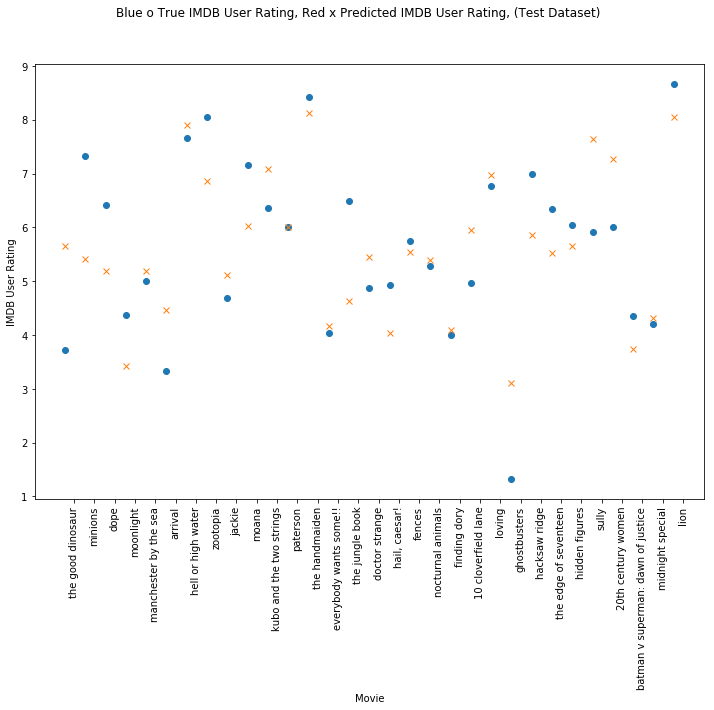

In [48]:
#Plot Of Predicted Values
plotx = []
width = .9
y_true, y_pred = [], []
plotx = list(non_zero_regression['title'][300:])
y_true = list(y[300:])
y_pred = list(reg_r.predict(x[300:]))
indexes = np.arange(len(plotx))
plt.plot(list(xrange(len(plotx))), y_true, "o")
plt.plot(list(xrange(len(plotx))), y_pred, "x")
plt.xticks(indexes + width * 0.5, plotx, rotation='vertical')
plt.suptitle("Blue o True IMDB User Rating, Red x Predicted IMDB User Rating, (Test Dataset)")
plt.ylabel('IMDB User Rating')
plt.xlabel('Movie')
plt.show()

In [49]:
non_zero_regression.to_csv("regression_dataset.csv")
final_google.to_csv("final_complete_dataset.csv")